# Pipeline 1: Did I Say That? A Machine Learning Chat Detective


---


# 1. Introduction

For the past 3 years and 4 months, my boyfriend Arthur and I have chatted on WhatsApp almost every single day. From cute good mornings to random deep conversations, our messages tell the story of how we got to know each other and how our relationship evolved. But what if a machine could learn to tell us apart just from the way we text?

This project is the start of an exploration of our communication styles using machine learning. I have a feeling my boyfriend is way more dry and direct than I am (while I probably overuse emojis, cute words, repeated letters, and exclamation marks). By training a model on our conversations, I want to see if these patterns hold up — and hopefully, this experiment won’t lead to a relationship discussion!

In this first draft assignment, I will focus on the patterns related to the content that the text messages have. I extracted more than 100k messages from our WhatsApp chat, and sampled from this dataset 10k messages, which were preprocessed and used to train and test a Naive Bayes classifier. After analyzing its performance, I also trained an SVM classifier and compared their performances. While achieving a reasonable results, there is still room for improvement.

Let’s dive into the data and see if the algorithm can figure out: *who wrote this text?*



---



## 2. Data
### 2.1 Data Description

I will use my Whatsapp chat with my boyfriend as data. It is important to note that he gave me permission to use this data in this assignment. I used regular expressions (regex) to extract structured data from the WhatsApp chat log and convert it into a pandas DataFrame for analysis. WhatsApp messages follow a specific format, including a timestamp, sender's name, and message content. Using regex, I identified this pattern and extracted only the relevant parts—ignoring system messages or formatting inconsistencies. I created a data frame with the sender and the message, and this is the data that I will use to train my model.



---



### 2.2 Load the Data & Data Cleaning

I will perform the process I described above in the code cell below.

In [9]:
# Specify the full file path
file_path = r'/Users/marianajannotti/Downloads/_chat.txt'

# Open and read the file
try:
    with open(file_path, mode='r', encoding="utf8") as file:
        data = file.read()
        print("File content successfully read!")
except FileNotFoundError:
    print(f"Error: The file at {file_path} was not found.")
except Exception as e:
    print(f"An error occurred: {e}")


File content successfully read!


In [10]:
import re
import pandas as pd


# Updated regex to capture both the sender's name and the message
pattern = re.compile(r'\[\d{1,2}/\d{1,2}/\d{2,4},\s*\d{1,2}:\d{2}:\d{2}\u202f?[APM]*\]\s+([^:]+):\s*(.*)')

# Extract (sender, message) pairs
messages = re.findall(pattern, data)


# Convert to DataFrame
if messages:
    df = pd.DataFrame(messages, columns=['Sender', 'Message'])
    df.to_csv("whatsapp_chat.csv", index=False)
else:
    print("No valid messages found!")

# change my boyfriend's cheesy nickname by his name
df["Sender"] = df["Sender"].replace("Momoziiiiii 💋💋😋😋", "Arthur")

df.head()


,Sender,Message
0,Arthur,‎Messages and calls are end-to-end encrypted. ...
1,Arthur,ei mari
2,Arthur,manda as fotos nossas por favor!!
3,Mariana Jannotti,ei tuxooo
4,Mariana Jannotti,‎image omitted


As shown in the head of the dataframe, some of the text messages in the extracted file include things like "Messages and calls are end-to-end encrypted" or "image omitted", which were not actually sent by any of us and instead is part of how WhatsApp extracts the text data. In the code cell below, I drop all the rows from the dataframe that include those kind of messages.

In [13]:
# Define the messages to be dropped
messages_to_drop = [
    "\u200eMessages and calls are end-to-end encrypted. No one outside of this chat, not even WhatsApp, can read or listen to them.",
    "\u200eimage omitted", "\u200esticker omitted", "\u200eThis message was deleted.", "\u200eYou deleted this message.", "\u200eaudio omitted", "\u200evideo omitted"
]

# Drop rows where the 'Message' column contains any of the specified messages
df = df[~df['Message'].isin(messages_to_drop)]
df = df[~df['Message'].str.contains('call', case=False, na=False)]

# Display the filtered DataFrame
df.head()


,Sender,Message
1,0,ei mari
2,0,manda as fotos nossas por favor!!
3,1,ei tuxooo
13,1,nao posta nenhuma kkk 🙏🏼
14,0,brigado!!


In [16]:
df["Sender"].value_counts().reset_index().rename(columns={"index": "Sender", "Sender": "message_count"})


,message_count,count
0,1,90980
1,0,69568




---


## 2.3 Data Pre-processing
For the sake of simplicity, I will label the senders as 1 (myself) and 0 (Arthur).

In [11]:
# Map labels (1 for Mariana, 0 for Arthur)
df["Sender"] = df["Sender"].map({"Mariana Jannotti": "1", "Arthur": "0"})


Before jumping into text preprocessing, I’ll first split the data into training and test sets to prevent any data leakage. Instead of using the entire dataset, I’ll randomly sample a smaller portion for both training and testing. Using the full dataset would create insanely large multidimensional vectors that would be difficult to handle. While I could explore ways to manage this in future assignments, for now, I want to keep things simple and work with a more manageable dataset. I will sample the same amount of text messages from each sender to try to have a balanced dataset, and the ratio of training data to testing data will be 90-10.

In [17]:

# Step 1: Balance the dataset by sampling 69,568 messages from Sender "0"
balanced_0 = df[df["Sender"] == "0"].sample(n=69568, random_state=42)
balanced_1 = df[df["Sender"] == "1"]  # Already has 69,568 messages

# Combine the balanced data
balanced_df = pd.concat([balanced_0, balanced_1])

# Step 2: Perform a 9:1 train-test split
train_0 = balanced_0.sample(frac=0.9, random_state=42)
train_1 = balanced_1.sample(frac=0.9, random_state=42)

test_0 = balanced_0.drop(train_0.index)  # Remaining 10%
test_1 = balanced_1.drop(train_1.index)  # Remaining 10%

# Step 3: Combine and shuffle the train and test datasets
train_df = pd.concat([train_0, train_1]).sample(frac=1, random_state=42)  # Shuffle
test_df = pd.concat([test_0, test_1]).sample(frac=1, random_state=42)  # Shuffle


Now that I have different test and train sets and I can guarantee that they will never see each other, we can talk about text preprocessing. When working with text data, we need to preprocess it so that a machine learning model can actually make sense of it. The tricky part is that text messages can vary in length and contain a diverse range of words. Essentially, the total set of words in our dataset represents the combined vocabulary that Arthur and I use, which is quite large! Words are categorical variables, but a naive approach like one-hot encoding wouldn't work well because the resulting vectors would be massive and sparse, making it an inefficient representation.

A common workaround is the **Bag of Words (BoW) model**, which tokenizes text into individual words and ignores their order. If we define $D$ as the total number of unique words (or tokens) in our dataset, we could represent each message as a $D$-dimensional vector where each element corresponds to the number of times a specific word appears in that message.

However, this approach comes with a problem: certain words appear frequently in many messages, even though they don’t carry much meaningful information. If we naively count occurrences, these words could dominate the representation of a message. That’s where **Term Frequency-Inverse Document Frequency (TF-IDF)** comes in.

TF-IDF helps balance word importance by scaling word frequency using logarithmic weighting. The key idea is to compute the **Inverse Document Frequency (IDF)**, which penalizes common words. It is defined as:

\begin{equation}
    \text{IDF}_i = \log \frac{N}{1 + \text{DF}_i}
\end{equation}

where $N$ is the total number of text messages and $\text{DF}_i$ is the number of messages containing word $i$. The addition of 1 in the denominator prevents division by zero.

Once we have the IDF values, we combine them with **Term Frequency (TF)**, which measures how often a word appears in a specific message. The TF-IDF score for word $i$ in message $j$ is then computed as:

\begin{equation}
    \text{TFIDF}_{ij} = \log(\text{TF}_{ij} + 1) \cdot \text{IDF}_i
\end{equation}

This formula ensures that frequently used but uninformative words are downweighted, while rare yet significant words get a higher score. By transforming our text data this way, we obtain a much more meaningful numerical representation that improves the classifier’s performance! While in the code cell below I define the vectorization process, I will not apply it to the data yet since I will be performing a cross-validation in the model. So, if I applied the TF-IDF now, there would be data leakage between the training and validation sets.

Additionally, before applying TF-IDF, I also want to remove stopwords, which are common words like *e* ("and") or *o* ("the") that increase the number of tokens without adding much meaning. While `TfidfVectorizer` from `sklearn` includes a built-in list of English stopwords, my messages are in Portuguese, so I defined my own stopword list based on similar principles.  

Lastly, I need to lemmatize the text before computing TF-IDF and removing stopwords. Words with the same meaning often appear in different forms (*corri*, *correu*, *correndo*), and lemmatization helps standardize them to a single base form (*correr*). This reduces the number of unique tokens while preserving the essential meaning of the text — just like converting *running* and *runs* into *run* in English.

In [18]:
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.feature_extraction import text
import spacy

# apply lemmatization

nlp = spacy.load('pt_core_news_sm')  # Load Portuguese language model

def lemmatize_text(text):
    doc = nlp(text)
    lemmatized_words = [token.lemma_ for token in doc]  # Extract lemmas
    return " ".join(lemmatized_words)

train_df["Message"] = train_df["Message"].apply(lemmatize_text)  # Apply lemmatization to the training set
test_df["Message"] = test_df["Message"].apply(lemmatize_text)  # Apply lemmatization to the test set




OSError: [E050] Can't find model 'pt_core_news_sm'. It doesn't seem to be a Python package or a valid path to a data directory.

In [26]:
# TF-IDF
# Add Portuguese stopwords
stopwords = [
    "a", "à", "agora", "ainda", "além", "algo", "alguém", "algum", "alguma", "algumas", "alguns",
    "ampla", "amplas", "amplo", "amplos", "ante", "antes", "ao", "aos", "após", "aquela", "aquelas",
    "aquele", "aqueles", "aquilo", "as", "até", "atrás", "cada", "caminho", "cima", "com", "como",
    "contra", "contudo", "da", "dá", "dão", "daquele", "daqueles", "das", "de", "dela", "delas",
    "dele", "deles", "demais", "dentro", "depois", "desde", "dessa", "dessas", "desse", "desses",
    "desta", "destas", "deste", "destes", "deve", "devem", "deverá", "direita", "do", "dois",
    "dos", "dessa", "dessas", "desse", "desses", "disto", "dito", "diz", "dizem", "dizer", "do", "dos",
    "e", "é", "ela", "elas", "ele", "eles", "em", "enquanto", "entre", "era", "eram", "éramos", "essa",
    "essas", "esse", "esses", "esta", "está", "estamos", "estão", "estar", "estas", "estava", "estavam",
    "estávamos", "este", "estes", "esteve", "estive", "estivemos", "estiver", "estivera", "estiveram",
    "estivermos", "estivesse", "estivessem", "estivéssemos", "estou", "eu", "faz", "fazer", "fez",
    "foi", "for", "fora", "foram", "fôramos", "fosse", "fossem", "fôssemos", "fui", "geral", "grande",
    "grandes", "há", "isso", "isto", "já", "lá", "lhe", "lhes", "lo", "mas", "me", "mesma", "mesmas",
    "mesmo", "mesmos", "meu", "meus", "minha", "minhas", "muita", "muitas", "muito", "muitos", "na",
    "não", "naquela", "naquelas", "naquele", "naqueles", "nas", "nem", "nenhum", "nessa", "nessas",
    "nesse", "nesses", "nesta", "nestas", "neste", "nestes", "ninguém", "no", "nos", "nós", "nossa",
    "nossas", "nosso", "nossos", "num", "numa", "nunca", "o", "os", "ou", "outra", "outras", "outro",
    "outros", "para", "pela", "pelas", "pelo", "pelos", "per", "perante", "pode", "pôde", "podem",
    "poderia", "poderiam", "podia", "pois", "por", "porque", "portanto", "posso", "pouca", "poucas",
    "pouco", "poucos", "primeiro", "primeiros", "própria", "próprias", "próprio", "próprios", "quais",
    "qual", "quando", "quanto", "quantos", "que", "quem", "quer", "quero", "quiser", "quis", "sabe",
    "sabem", "se", "seja", "sejam", "sejamos", "sem", "sempre", "sendo", "ser", "será", "serão",
    "seria", "seriam", "seu", "seus", "si", "sido", "só", "sob", "sobre", "sua", "suas", "talvez",
    "também", "tampouco", "te", "tem", "têm", "tendo", "tenha", "tenham", "tenhamos", "tenho", "tentar",
    "tente", "tentei", "ter", "terá", "terão", "teria", "teriam", "teríamos", "teu", "teus", "teve",
    "tinha", "tinham", "tivemos", "tiver", "tivera", "tiveram", "tivermos", "tivesse", "tivessem",
    "tivéssemos", "toda", "todas", "todo", "todos", "trás", "tu", "tua", "tuas", "tudo", "última",
    "últimas", "último", "últimos", "um", "uma", "umas", "uns", "vendo", "ver", "vez", "vindo", "vir",
    "você", "vocês", "vos", "vós", "vc", "to", "ok", "la", "pra", "mt", "nao", "sim", "ta", "ai",
    "kkkkkkk", "kkkkkk", "kkkkkkkkk", "kkkkkkkkk","kkkkkkkkkkk" , "kkkkkkkkkk", "kkkkkkkkkkkk",
    "vai", "kkkkk", "kkkkkkkk", "vou", "ja", "q", "ir", "pq", "aqui", "achar", "kkkkkkr",
    "https", "tbm", "kkkkkkkkkkkkk"]

# Convert stopwords to a list
stop_words_pt = list(text.ENGLISH_STOP_WORDS) + stopwords

vectorizer = TfidfVectorizer(stop_words=stop_words_pt, token_pattern=r'\b[a-zA-Z]+\b')


While in the previous assignment I used a vectorized approach, for this assigned I will use transfer learning by using a BERT model.

In [6]:
import torch
print(torch.__version__)


2.6.0


In [7]:
from transformers import BertTokenizer, BertModel
import torch

# Load pre-trained BERT model and tokenizer
tokenizer = BertTokenizer.from_pretrained("neuralmind/bert-base-portuguese-cased")
model = BertModel.from_pretrained("neuralmind/bert-base-portuguese-cased")

def get_bert_embeddings(text):
    inputs = tokenizer(text, return_tensors="pt", padding=True, truncation=True, max_length=512)
    with torch.no_grad():  # Disable gradient computation for efficiency
        outputs = model(**inputs)
    return outputs.last_hidden_state[:, 0, :].squeeze().numpy()  # Use [CLS] token representation


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [8]:
# Apply the function to get BERT embeddings for the training set
train_df['bert_embeddings'] = train_df['Message'].apply(get_bert_embeddings)

# Apply the function to get BERT embeddings for the testing set
test_df['bert_embeddings'] = test_df['Message'].apply(get_bert_embeddings)



---


## 2.5 Exploratory Data Analysis

Looking at the summary of our complete chat data (see the table below), a few interesting things pop out! First, we’ve exchanged 160,548 messages in total — pretty impressive. Out of these, I sent 90,980 messages, while Arthur sent 69,568 (which means I talk more… not surprising). When it comes to unique messages, there are 104,097 different ones, so we do repeat ourselves quite a bit. And speaking of repetition, the most common message in our chat is "sim" ("yes"), which was sent 1,821 times — looks like we agree with each other a lot!

In [27]:
df.describe()

,Sender,Message
count,160548,160548
unique,2,106255
top,1,sim
freq,90980,1388


Note that the description above was regarding the whole dataset, before the preprocessing. Below is the description of the train and test sets. It is interesting to note that the top messages were "sim" ("yes") and "kkkkkkk" ("hahaha"), which are not very informative in meanining. This explains the need for the preprocessing described above.

In [28]:
train_df.describe()

,Sender,Message
count,18000,18000
unique,2,13335
top,0,sim
freq,9000,215


In [29]:
test_df.describe()

,Sender,Message
count,2000,2000
unique,2,1700
top,1,kkkkkkk
freq,1000,22


Now, let's analyze the dataset after the TF-IDF transformation. Below, there is a wordcloud of the most popular words (tokenized) that we use. The most popular words, like "baby" (I know, very cheesy, is how we call each other), "ir" ("go"), "casa"("home"), "bom" ("good") and "dia" ("morning") makes sense as they are very common on our daily conversations. I also made a wordcloud for the test and training samples. They are very similar to the whole dataset wordcloud, which shows that the random samples are representative.

As another way to visualize the same information, I plotted a bar plot of the 20 most common words, and a heatmap of them.

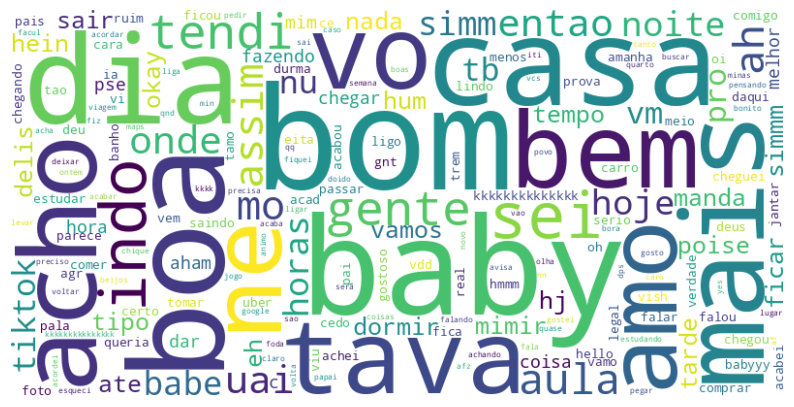

In [30]:
# word cloud for the whole dataset
from wordcloud import WordCloud
import matplotlib.pyplot as plt

# apply TF-IDF
tfidf_matrix = vectorizer.fit_transform(df["Message"])

# Get feature names (words) and their frequencies
words = vectorizer.get_feature_names_out()
word_frequencies = tfidf_matrix.sum(axis=0).A1  # Sum across all documents to get word frequencies

# Create a dictionary of words and their frequencies
word_freq_dict = dict(zip(words, word_frequencies))

# Create and display the word cloud
wordcloud = WordCloud(width=800, height=400, background_color="white").generate_from_frequencies(word_freq_dict)

plt.figure(figsize=(10, 8))
plt.imshow(wordcloud, interpolation="bilinear")
plt.axis('off')
plt.show()

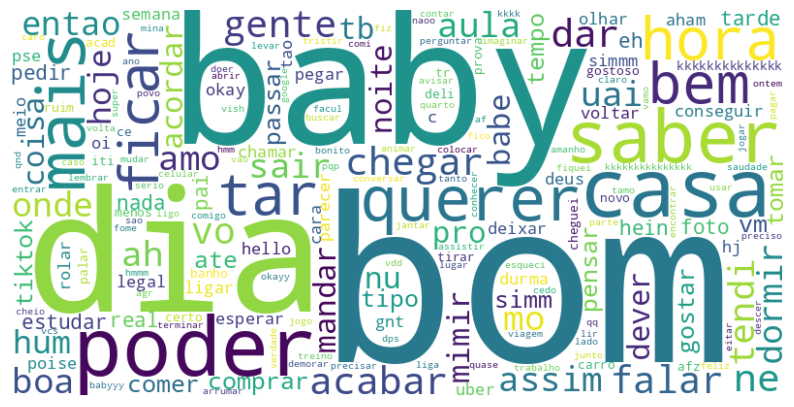

In [31]:
# word cloud for the training set
# apply TF-IDF
tfidf_matrix_train = vectorizer.fit_transform(train_df["Message"])

# Get feature names (words) and their frequencies
words_train = vectorizer.get_feature_names_out()
word_train_frequencies = tfidf_matrix_train.sum(axis=0).A1  # Sum across all documents to get word frequencies

# Create a dictionary of words and their frequencies
word_train_freq_dict = dict(zip(words_train, word_train_frequencies))

# Create and display the word cloud
wordcloud_train = WordCloud(width=800, height=400, background_color="white").generate_from_frequencies(word_train_freq_dict)

plt.figure(figsize=(10, 8))
plt.imshow(wordcloud_train, interpolation="bilinear")
plt.axis('off')
plt.show()


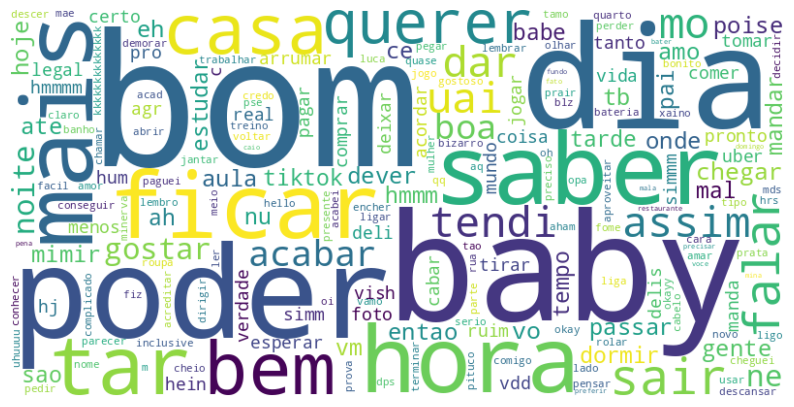

In [32]:
# word cloud for the test set
# apply TF-IDF
tfidf_matrix_test = vectorizer.fit_transform(test_df["Message"])

# Get feature names (words) and their frequencies
words_test = vectorizer.get_feature_names_out()
word_frequencies_test = tfidf_matrix_test.sum(axis=0).A1  # Sum across all documents to get word frequencies

# Create a dictionary of words and their frequencies
word_freq_dict_test = dict(zip(words_test, word_frequencies_test))

# Create and display the word cloud
wordcloud_test = WordCloud(width=800, height=400, background_color="white").generate_from_frequencies(word_freq_dict_test)

plt.figure(figsize=(10, 8))
plt.imshow(wordcloud_test, interpolation="bilinear")
plt.axis('off')
plt.show()


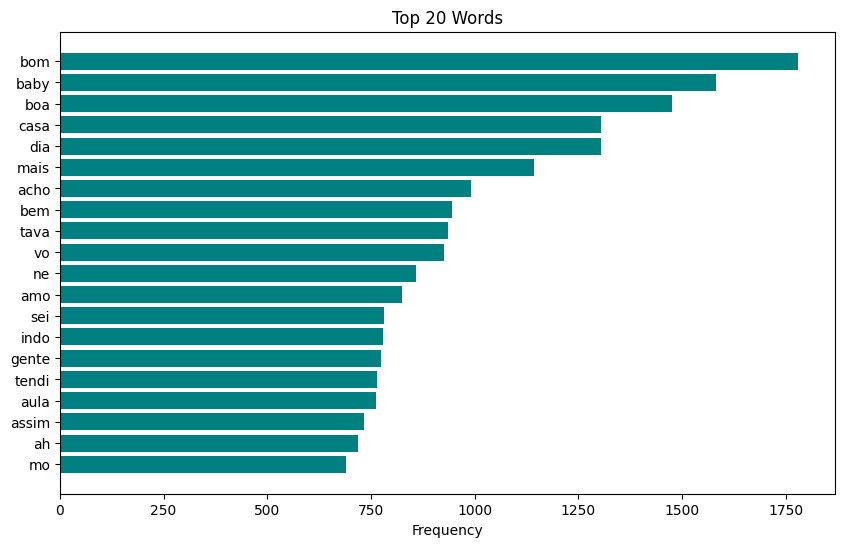

In [33]:
import numpy as np

# Get top N words
N = 20
top_n_idx = np.argsort(word_frequencies)[::-1][:N]
top_n_words = [words[i] for i in top_n_idx]
top_n_freqs = [word_frequencies[i] for i in top_n_idx]

# Plot the bar chart
plt.figure(figsize=(10, 6))
plt.barh(top_n_words, top_n_freqs, color='teal')
plt.xlabel('Frequency')
plt.title(f'Top {N} Words')
plt.gca().invert_yaxis()  # Reverse the order
plt.show()


It is also interesting to see how the most common words will change based on the sender. In the plots below, I can see that there is a lot of overlap between the most popular words that Arthur use and that I use. This includes "good" "morning" and "baby", for instance, that both of us uses a lot (e.g. everyday he sends me a "Good morning, baby", and I reply with a "Good morning, baby"). This overlap might make the model's job a bit harder.

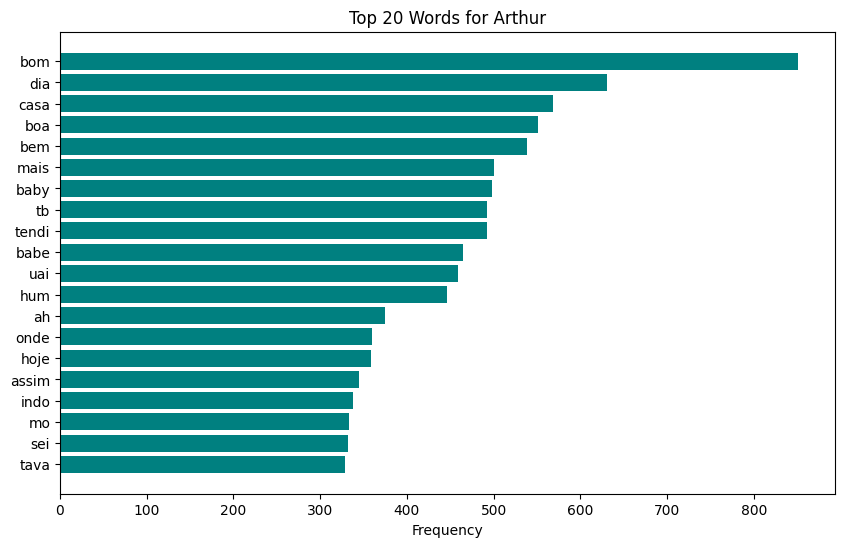

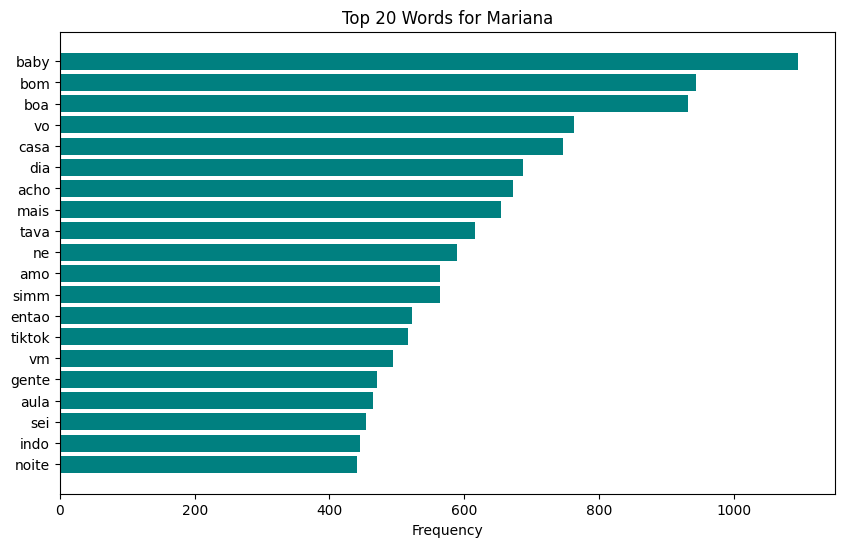

In [34]:
# Function to generate word cloud and bar chart for a specific sender
def plot_top_words_for_sender(sender_id, sender_name):
    # Filter messages for the given sender
    sender_messages = df[df["Sender"] == sender_id]["Message"]

    # Apply TF-IDF
    tfidf_matrix = vectorizer.fit_transform(sender_messages)

    # Get feature names (words) and their frequencies
    words = vectorizer.get_feature_names_out()
    word_frequencies = tfidf_matrix.sum(axis=0).A1  # Sum across all documents to get word frequencies

    # Get top N words
    N = 20
    top_n_idx = np.argsort(word_frequencies)[::-1][:N]
    top_n_words = [words[i] for i in top_n_idx]
    top_n_freqs = [word_frequencies[i] for i in top_n_idx]

    # Plot the bar chart
    plt.figure(figsize=(10, 6))
    plt.barh(top_n_words, top_n_freqs, color='teal')
    plt.xlabel('Frequency')
    plt.title(f'Top {N} Words for {sender_name}')
    plt.gca().invert_yaxis()  # Reverse the order
    plt.show()

# Plot for Sender 0 (Arthur)
plot_top_words_for_sender("0", "Arthur")

# Plot for Sender 1 (Mariana)
plot_top_words_for_sender("1", "Mariana")






---


# 4. Model Selection and Explanation


The Naive Bayes classifier is a simple yet powerful probabilistic classifier based on Bayes' theorem, with a particular focus on the multinomial distribution when applied to text data. This distribution is well-suited for discrete features (such as word counts or TF-IDF values) and models the probability of a word occurring in a given class.

Bayes' theorem provides a way to update the probability of a hypothesis based on new evidence. The general form of Bayes' theorem is:

$$
P(C \mid X) = \frac{P(X \mid C) P(C)}{P(X)}
$$

Where:
  

*  $ P(C \mid X) $ is the **posterior probability**, or the probability
that class $C$ is true given the evidence $X$.
*  $ P(X \mid C) $ is the **likelihood**, or the probability of observing the evidence $ X $ given the class $ C $.
* $ P(C) $ is the **prior probability**, or the probability of the class $ C $ before seeing any evidence.
* $P(X)$ is the **marginal likelihood**, or the probability of observing the evidence $ X $ across all classes.


In text classification, we aim to classify a message $X$ as belonging to one of two classes: from me (denoted as class $ C_{\text{me}} $) or from Arthur (denoted as class $ C_{\text{Arthur}} $). The message $ X $ is represented as a TF-IDF vector: $ X = (x_1, x_2, \dots, x_n) $, where each $ x_i $ corresponds to the TF-IDF weight of the $i$-th term in our vocabulary.

Using Bayes' theorem, the probability of the message $ X $ being from class $ C $ is:

$$
P(C \mid X) = \frac{P(X \mid C) P(C)}{P(X)}
$$

We assume that the words in the message are conditionally independent given the class. This is the **naive** assumption in the Naive Bayes classifier. With this assumption, we can factor the likelihood $ P(X \mid C) $ as:

$$
P(X \mid C) = P(x_1, x_2, \dots, x_n \mid C) = \prod_{i=1}^{n} P(x_i \mid C)
$$

Thus, the posterior probability becomes:

$$
P(C \mid X) = \frac{P(C) \prod_{i=1}^{n} P(x_i \mid C)}{P(X)}
$$

In practice, we don’t need to calculate $ P(X) $ (the marginal likelihood), since it is the same for all classes. So, we can focus on maximizing $ P(C \mid X) $ with respect to $ C $. The class that maximizes the posterior probability $ P(C \mid X) $ is the predicted class:

$$
\hat{C} = \arg\max_C P(C) \prod_{i=1}^{n} P(x_i \mid C)
$$


To estimate the probabilities $ P(C) $ and $ P(x_i \mid C) $, we use Maximum Likelihood Estimation (MLE). MLE is a method for estimating the parameters of a statistical model that maximizes the likelihood of the observed data.

1. **Prior Probability $ P(C) $:**

The prior probability of each class is estimated as the proportion of each class in the training dataset. In this case, as the sampled dataset is completely balanced, we have that:

$$
P(C_{\text{me}}) = 0.5
$$
$$
P(C_{\text{Arthur}}) = 0.5
$$

2. **Likelihood $ P(x_i \mid C) $:**

The likelihood $ P(x_i \mid C) $ represents the probability of observing a word $ x_i $ given a class $ C $. Using MLE, we estimate it as the frequency of word $ x_i $ in class $ C $ divided by the total number of words in that class. Specifically:

$$
P(x_i \mid C) = \frac{\text{Count of } x_i \text{ in class } C}{\text{Total number of words in class } C}
$$

To handle cases where a word might not appear in the training data for a given class, we use **Laplace smoothing**. This adjusts the probabilities by adding a small constant (usually 1) to each count.

$$
P(x_i \mid C) = \frac{\text{Count of } x_i \text{ in class } C + 1}{\text{Total number of words in class } C + V}
$$

Where $ V $ is the number of unique words in the vocabulary. Figure 1 illustrates the intuition behind this process.

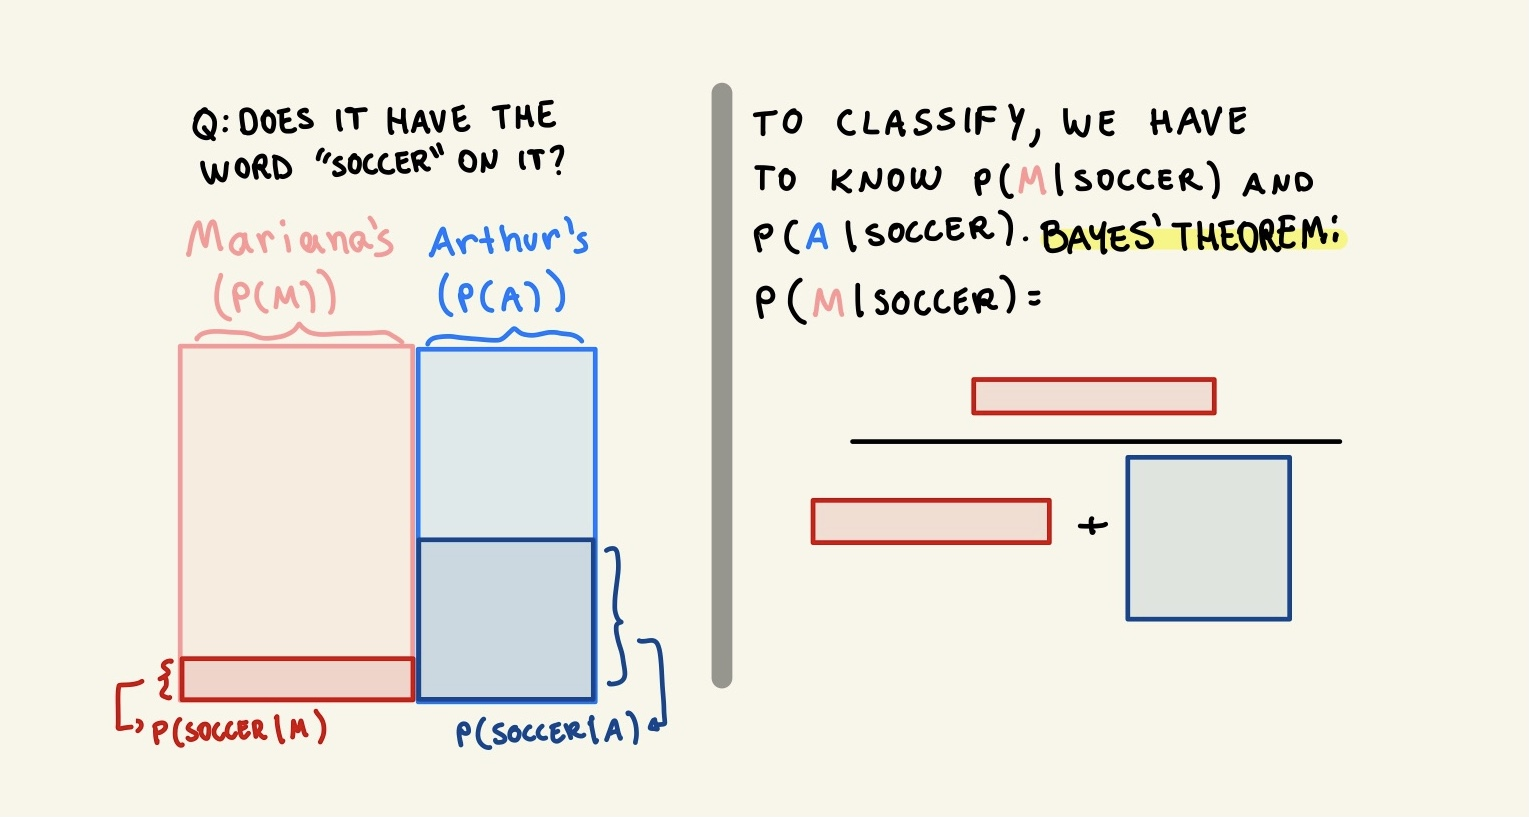
**Figure 1.** *Applying Bayes' Theorem to classify a message as being sent from Arthur or from Mariana.* This figure illustrates how to calculate the probability of being from a class given the word "soccer". On the multinomial naive bayes, this process would be repeated for all the tokenized words in the message in order to calculate the likelihood.

The pseudocode below showcases how the Multinomial Naive Bayes will be applied in the context of this assignment.





```
# Step 1: Preprocess the data
# - Convert the text messages to TF-IDF representations
# - Each message is represented as a vector of TF-IDF values for words/features
# - Prepare training and test datasets (e.g., labeled as 'Mariana - 1' or 'Arthur - 0')

# Step 2: Train the model
# Initialize the prior and likelihood dictionaries for each class (Mariana, Arthur)
for each class in ['Mariana', 'Arthur']:
    # Calculate prior probability P(class) = count(class) / total_samples
    prior[class] = count(class) / total_samples
    
    # Calculate the likelihood P(feature|class) using the multinomial distribution
    for each feature in features:  # features are TF-IDF values for each word
        # Multinomial likelihood: P(feature|class) = (sum(TFIDF(feature in class)) + smoothing) / (sum(TFIDF in class) + V)
        likelihood[class][feature] = (sum(TFIDF of feature in class) + smoothing) / (sum(TFIDF values in class) + V)

# Step 3: Make predictions
for each test_message in test_data:
    posterior = {}
    
    # For each class (Mariana or Arthur), calculate the posterior probability P(class|features)
    for each class in ['Mariana', 'Arthur']:
        # Start with the prior probability P(class)
        posterior[class] = prior[class]
        
        # Multiply by the likelihood of each feature (TF-IDF value) given the class (using multinomial distribution)
        for each feature in test_message:  # test_message is a vector of TF-IDF values
            # P(class|features) = P(class) * P(features|class)
            # Update the probability using the multinomial likelihood
            posterior[class] *= likelihood[class].get(feature, 0)  # handle unseen features by returning 0 if not found
    
    # Choose the class with the highest posterior probability (either 'Mariana' or 'Arthur')
    predicted_class = argmax(posterior)
    
# Step 4: Evaluate model performance (e.g., accuracy, precision)

```



# 5. Training and Validation

Below is my implementation of the multinomial naive bayes classifier using the sklearn library. I will be using a K-fold cross-validation, which helps me test how well the model performs on different parts of the data, ensuring it’s not just memorizing specific cases but actually learning something useful that works across the board.

In [39]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.model_selection import cross_val_score, StratifiedKFold
from sklearn.pipeline import Pipeline
from sklearn.naive_bayes import MultinomialNB
from sklearn.metrics import (accuracy_score, confusion_matrix, classification_report,
                             precision_recall_fscore_support, roc_curve, auc)

# Load training data
X_train = train_df["Message"]
y_train = train_df["Sender"]

# Load test data
X_test = test_df["Message"]
y_test = test_df["Sender"]

# Define pipeline: TF-IDF Vectorizer + Naive Bayes Classifier
pipeline_bayes = Pipeline([
    ('tfidf', vectorizer),  # Fit TF-IDF on each fold separately
    ('clf', MultinomialNB())       # Train Naive Bayes classifier
])

# Perform Stratified K-Fold Cross-Validation
kf = StratifiedKFold(n_splits=10, shuffle=True, random_state=42)
cv_scores = cross_val_score(pipeline_bayes, X_train, y_train, cv=kf, scoring='accuracy')

# Train model on full training set
pipeline_bayes.fit(X_train, y_train)

# Evaluate on test set
y_pred = pipeline_bayes.predict(X_test)







---


# 6. Performance Evaluation

Mean Accuracy (Cross-Validation): 0.6746
Standard Deviation: 0.0093
Test Accuracy: 0.6740
Classification Report:
               precision    recall  f1-score   support

      Arthur       0.64      0.81      0.71      1000
     Mariana       0.74      0.53      0.62      1000

    accuracy                           0.67      2000
   macro avg       0.69      0.67      0.67      2000
weighted avg       0.69      0.67      0.67      2000

Precision: 0.6890, Recall: 0.6740, F1-score: 0.6674


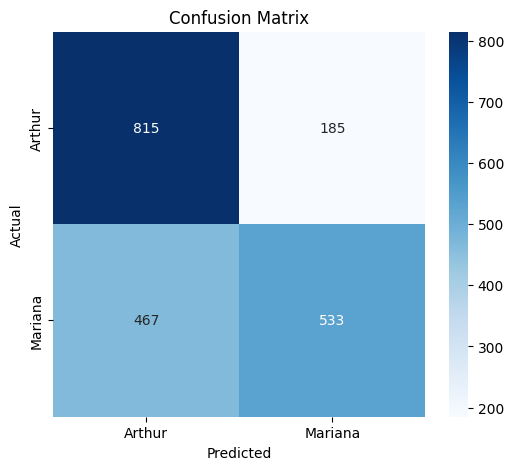

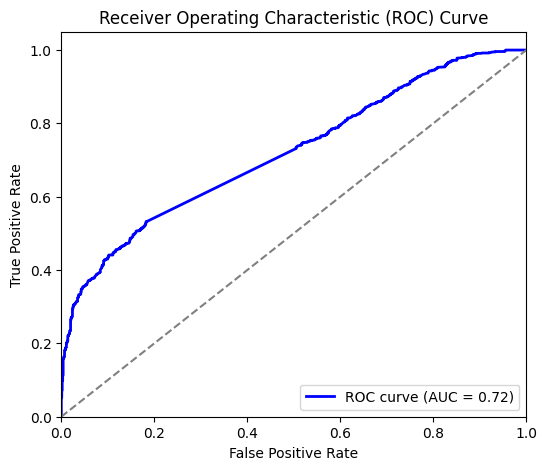

In [40]:
# Compute accuracy and classification report
test_accuracy = accuracy_score(y_test, y_pred)
report = classification_report(y_test, y_pred, target_names=["Arthur", "Mariana"])

# Print cross-validation results
print(f"Mean Accuracy (Cross-Validation): {cv_scores.mean():.4f}")
print(f"Standard Deviation: {cv_scores.std():.4f}")

print(f"Test Accuracy: {test_accuracy:.4f}")
print("Classification Report:\n", report)

# Compute precision, recall, and F1-score
precision, recall, f1, _ = precision_recall_fscore_support(y_test, y_pred, average='weighted')
print(f"Precision: {precision:.4f}, Recall: {recall:.4f}, F1-score: {f1:.4f}")

# Confusion Matrix
conf_matrix = confusion_matrix(y_test, y_pred)

# Confusion Matrix
plt.figure(figsize=(6,5))
sns.heatmap(conf_matrix, annot=True, fmt="d", cmap="Blues", xticklabels=["Arthur", "Mariana"], yticklabels=["Arthur", "Mariana"])
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.title("Confusion Matrix")
plt.show()

# ROC Curve
y_prob = pipeline_bayes.predict_proba(X_test)[:, 1]  # Get probabilities for class 1
fpr, tpr, _ = roc_curve(y_test.astype(int), y_prob)
roc_auc = auc(fpr, tpr)

# Plot ROC Curve
plt.figure(figsize=(6,5))
plt.plot(fpr, tpr, color="blue", lw=2, label=f"ROC curve (AUC = {roc_auc:.2f})")
plt.plot([0, 1], [0, 1], color="gray", linestyle="--")  # Random guess line
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("Receiver Operating Characteristic (ROC) Curve")
plt.legend(loc="lower right")
plt.show()


Let’s dive into my model’s performance. So, looking at the confusion matrix, it seems like the model is doing pretty well at picking up messages from Arthur, correctly identifying 815 of them as True Negatives (TN). But there’s still some mischief happening with 185 messages that get wrongly labeled as Mariana's (False Positives). On the flip side, when it comes to my messages, the model nails 533, but misses 467 — those are the False Negatives (FN), where it mistakenly thinks you’re Arthur.

Now, let’s talk numbers: For Arthur's texts, the model has precision at 64%, meaning when it says "It's Arthur," it's correct about 64% of the time. Not bad, but it could get a little sharper. However, it’s really good at identifying Arthur's messages with a recall of 81%, meaning it catches 81% of all messages that actually come from him.

Now, for my messages, the precision is 74%, meaning when it guesses "It's Mariana," it’s right 74% of the time. Pretty solid! But it misses about 47% of my messages, with a recall of 53%. So, there’s definetely some room for improvement to make sure it doesn’t overlook your texts. The F1-score for my messages is 0.62, which shows a balance between precision and recall but suggests that it could do better at both.

As shown by the ROC curve, the model does better than random guesses, which is great! Overall, it is great at spotting Arthur, but sometimes it's a little too eager when labeling my messages as his.

---

## 6.2 SVM as an alternative model

If I changed the model, would the performance metrics improve?

Let's dive into the magic of Support Vector Machines (SVM) and see how it can be applied to this classification task. Given that the messages have already been preprocessed using TF-IDF, we can think of each message as a vector of features that captures the importance of different words in the text.

In essence, an SVM is a supervised learning algorithm that constructs a hyperplane (or a set of hyperplanes in higher dimensions) that best separates data into different classes. The goal of the SVM is to maximize the **margin** between the two classes while correctly classifying as many data points as possible. The **margin** is defined as the distance between the hyperplane and the closest data points, which are known as **support vectors**. These support vectors are critical since they are the points that define the decision boundary.

Mathematically, the optimization problem SVM tries to solve can be formulated as:

$$
\underset{\mathbf{w}, b}{\text{maximize}} \ \frac{2}{\|\mathbf{w}\|}
$$

where ($\mathbf{w} $\) is the vector normal to the hyperplane, and ($b$\) is the bias term. This equation essentially tells us that we want to maximize the distance between the hyperplane and the support vectors to ensure a robust classifier.

However, the real world isn’t always as neat as we'd like it to be, so not all data points can be perfectly separated by a hyperplane. To account for this, we introduce **slack variables** ($\xi_i$\) for each data point, which allow for some misclassification if necessary. This leads to the following optimization problem:

$$
\underset{\mathbf{w}, b, \xi_i}{\text{minimize}} \ \frac{1}{2} \|\mathbf{w}\|^2 + C \sum_{i=1}^{n} \xi_i
$$

Here, ($C$\) is a regularization parameter that controls the trade-off between maximizing the margin and minimizing classification errors. A larger \($C$\) reduces the allowable misclassification but may lead to overfitting, whereas a smaller ($C$\) allows for more misclassification, favoring a simpler, more generalized model. The term ($\frac{1}{2} \|\mathbf{w}\|^2 $\) ensures that we minimize the complexity of the model, helping it generalize better to unseen data.

Once the model has been trained and the hyperplane has been determined, we can use it to classify new messages. Given a new message, we convert it into a TF-IDF vector and compute its position relative to the hyperplane. If the new message lies on the "Arthur" side of the hyperplane, it is classified as a message from him, and if it falls on the "Mariana" side, it’s classified as one of mine. Figure 2 is an illustration of how SVM works.

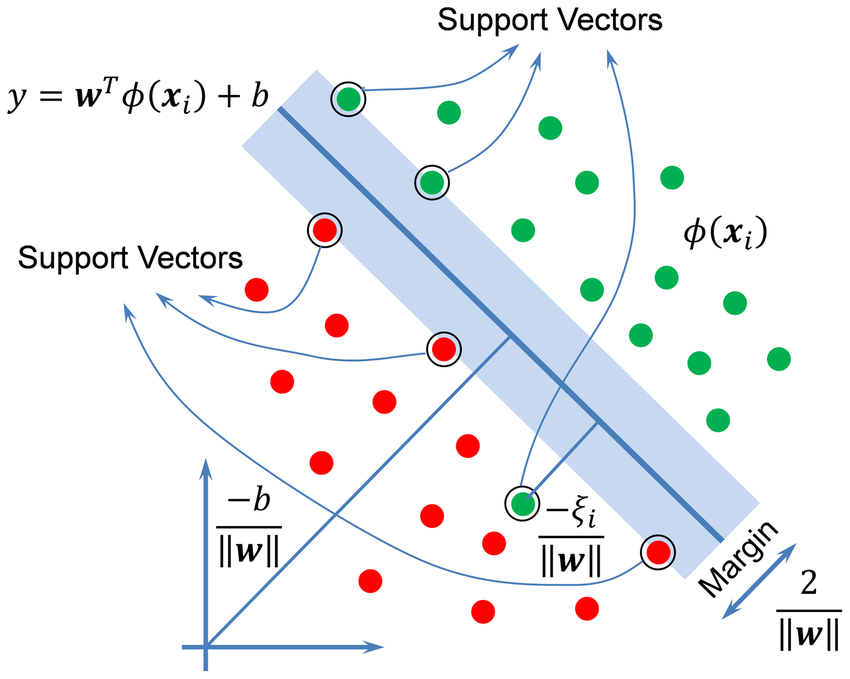

**Figure 2.** *Geometric description of SVM.* Source: https://www.google.com/url?sa=i&url=https%3A%2F%2Fwww.researchgate.net%2Ffigure%2FGeometric-description-of-SVM-for-a-binary-classification-problem_fig14_224050262&psig=AOvVaw2LZMvwwj0sQ4pvY2qpBHyw&ust=1740355276565000&source=images&cd=vfe&opi=89978449&ved=0CBcQjhxqFwoTCLjwnuW-2IsDFQAAAAAdAAAAABAh

Below is a pseudocode that summarizes the implementation of SVM:



```
# Step 1: Preprocess the data
# - Convert the text messages to TF-IDF representations
# - Each message is represented as a vector of TF-IDF values for words/features
# - Prepare training and test datasets (e.g., labeled as 'Mariana - 1' or 'Arthur - 0')

# Step 2: Initialize the SVM model
# Choose a kernel function (e.g., linear, RBF, or polynomial)
# Set the regularization parameter C
# Initialize weight vector w and bias b

# Step 3: Train the SVM model
for each data_point (x_i, y_i) in training_data:
    # If the data point is on the wrong side of the margin:
    if y_i * (w * x_i + b) < 1:
        # Update the weight vector w and bias b using the gradient of the hinge loss
        w = w - learning_rate * (w - C * y_i * x_i)
        b = b - learning_rate * (-C * y_i)
    else:
        # If the data point is on the correct side, no update needed
        pass

# Step 4: Make predictions on the test set
for each test_message x_test in test_data:
    # Calculate the decision function f(x_test) = w * x_test + b
    f_x_test = w * x_test + b

    # Classify as 'Mariana' if f(x_test) > 0, else classify as 'Arthur'
    if f_x_test > 0:
        predicted_class = 'Mariana'
    else:
        predicted_class = 'Arthur'

# Step 5: Evaluate model performance (e.g., accuracy, precision, recall)
```




The beauty of SVM lies in its ability to handle high-dimensional data efficiently, especially when combined with TF-IDF for text classification. By using the inner product ($\langle \mathbf{x}_i, \mathbf{x}_j \rangle$\), we can even map our data to a higher-dimensional space using the **kernel trick**, which allows us to separate non-linearly separable data by transforming it into a space where a hyperplane can be used effectively.

In conclusion, SVM is an ideal choice for this classification problem due to its ability to maximize the margin, handle high-dimensional spaces efficiently, and deal with noisy data through the use of slack variables. It provides a clear decision boundary that can separate the messages with precision, ensuring that the model doesn't simply memorize specific examples but generalizes well to new, unseen messages.

Mean Accuracy (Cross-Validation): 0.6815
Standard Deviation: 0.0088
Test Accuracy: 0.6755
Classification Report:
               precision    recall  f1-score   support

      Arthur       0.65      0.77      0.70      1000
     Mariana       0.72      0.58      0.64      1000

    accuracy                           0.68      2000
   macro avg       0.68      0.68      0.67      2000
weighted avg       0.68      0.68      0.67      2000

Precision: 0.6823, Recall: 0.6755, F1-score: 0.6724


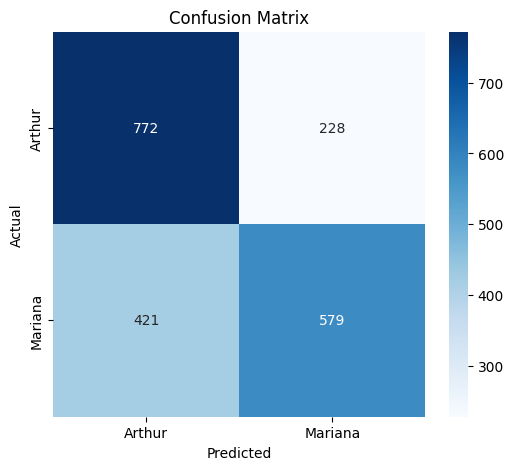

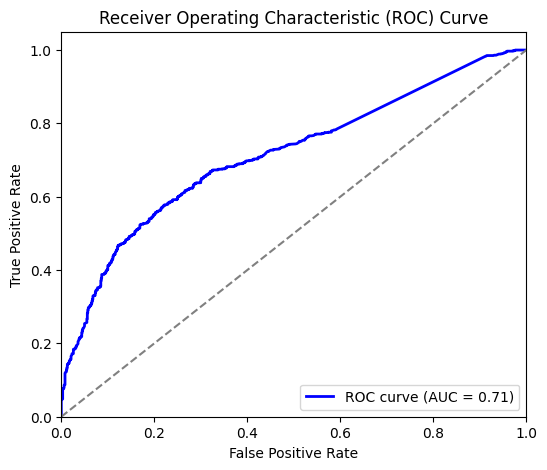

In [37]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.model_selection import cross_val_score, StratifiedKFold
from sklearn.pipeline import Pipeline
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.svm import SVC  # Import SVM
from sklearn.metrics import (accuracy_score, confusion_matrix, classification_report,
                             precision_recall_fscore_support, roc_curve, auc)

# Load training data
X_train = train_df["Message"]
y_train = train_df["Sender"]

# Load test data
X_test = test_df["Message"]
y_test = test_df["Sender"]

# Define pipeline: TF-IDF Vectorizer + SVM Classifier
pipeline = Pipeline([
    ('tfidf', vectorizer),  # Use TfidfVectorizer defined earlier
    ('clf', SVC(probability=True))  # Use SVM classifier and enable probability estimates
])

# Perform Stratified K-Fold Cross-Validation
kf = StratifiedKFold(n_splits=10, shuffle=True, random_state=42)
cv_scores = cross_val_score(pipeline, X_train, y_train, cv=kf, scoring='accuracy')

# Print cross-validation results
print(f"Mean Accuracy (Cross-Validation): {cv_scores.mean():.4f}")
print(f"Standard Deviation: {cv_scores.std():.4f}")

# Train model on full training set
pipeline.fit(X_train, y_train)

# Evaluate on test set
y_pred = pipeline.predict(X_test)

# Compute accuracy and classification report
test_accuracy = accuracy_score(y_test, y_pred)
report = classification_report(y_test, y_pred, target_names=["Arthur", "Mariana"])

print(f"Test Accuracy: {test_accuracy:.4f}")
print("Classification Report:\n", report)

# Compute precision, recall, and F1-score
precision, recall, f1, _ = precision_recall_fscore_support(y_test, y_pred, average='weighted')
print(f"Precision: {precision:.4f}, Recall: {recall:.4f}, F1-score: {f1:.4f}")

# Confusion Matrix
conf_matrix = confusion_matrix(y_test, y_pred)

# Plot Confusion Matrix
plt.figure(figsize=(6,5))
sns.heatmap(conf_matrix, annot=True, fmt="d", cmap="Blues", xticklabels=["Arthur", "Mariana"], yticklabels=["Arthur", "Mariana"])
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.title("Confusion Matrix")
plt.show()

# ROC Curve
y_prob = pipeline.predict_proba(X_test)[:, 1]  # Get probabilities for class 1
fpr, tpr, _ = roc_curve(y_test.astype(int), y_prob)
roc_auc = auc(fpr, tpr)

# Plot ROC Curve
plt.figure(figsize=(6,5))
plt.plot(fpr, tpr, color="blue", lw=2, label=f"ROC curve (AUC = {roc_auc:.2f})")
plt.plot([0, 1], [0, 1], color="gray", linestyle="--")  # Random guess line
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("Receiver Operating Characteristic (ROC) Curve")
plt.legend(loc="lower right")
plt.show()


Even though the expectations for SVM were high, the results are a bit disappointing. As shown by the plot and the metrics table, the performance was quite similar to the one from the multinomial naive bayes.


---



# 7. Visualization and Insights

To figure out how my naive bayes model is doing, I took a look at the log probabilities for the top 30 words in each class. When I compared the words with the highest P(X|Mariana) and P(X|Arthur), I noticed there’s a bit of overlap. This could be the "noise" messing with the model's ability to tell us apart. Honestly, I think Arthur and I have been together for so long that we have absorbed each other's vocabularies, which is making it tricky for the model to distinguish between us based on just the words we use. The fact that a more robust model such as SVM could not improve much the results shows that the problem with the performance is not blamed on the model choice.

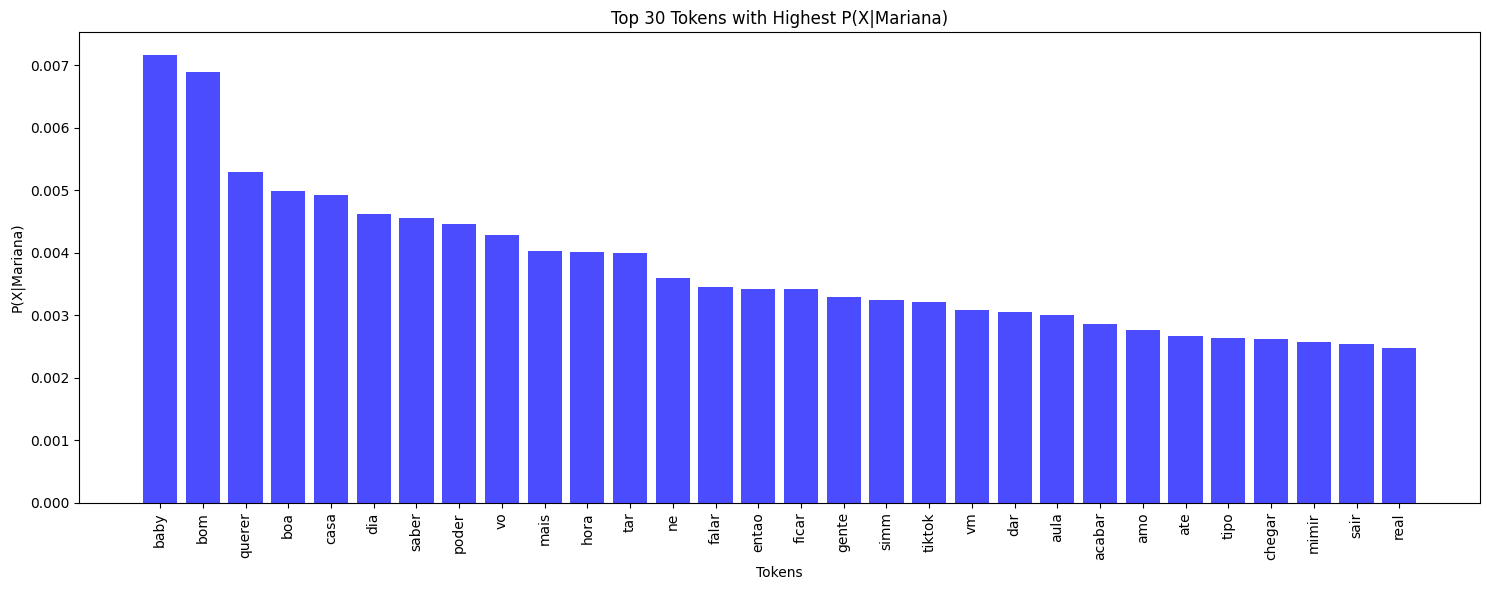

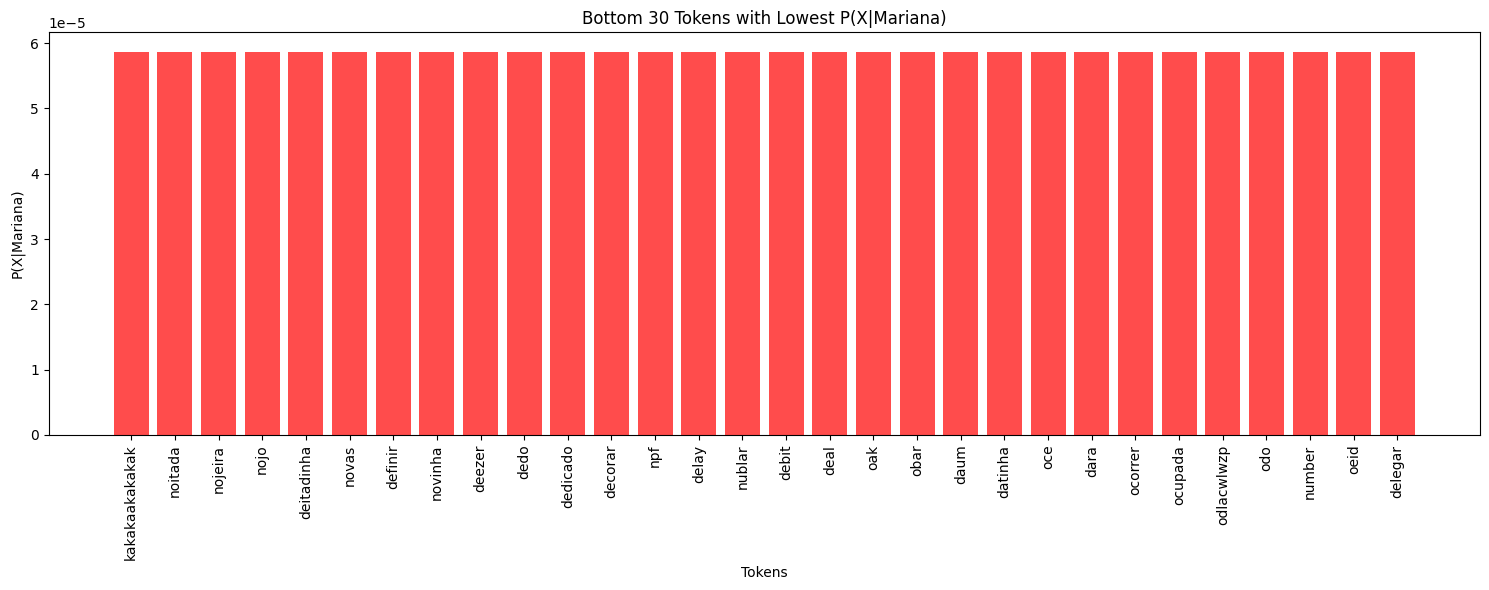

In [41]:
# This code was adpated from the Pre-Class Workbook from Session 5: Max Likelihood 1: Naive Bayes

# Access the fitted model and vectorizer from the pipeline
pipeline_vectorizer = pipeline_bayes.named_steps['tfidf']  # Access the TfidfVectorizer
model = pipeline_bayes.named_steps['clf']  # Access the Naive Bayes classifier

# Extract feature log probabilities for both classes (Arthur and Mariana)
feature_log_prob = model.feature_log_prob_

# Extract token names from the vectorizer's vocabulary
vocabulary = pipeline_vectorizer.vocabulary_
tokens = np.array(sorted(vocabulary, key=vocabulary.get))  # Sort by index order

# For myself
feature_prob_mariana = np.exp(feature_log_prob[1])  # P(X|Mariana)

# Sort tokens by probability (descending and ascending)
sorted_indices_desc = np.argsort(-feature_prob_mariana)[:30]  # Top 30
sorted_indices_asc = np.argsort(feature_prob_mariana)[:30]    # Bottom 30

# Prepare data for plotting
top_tokens = tokens[sorted_indices_desc]
top_probs = feature_prob_mariana[sorted_indices_desc]
low_tokens = tokens[sorted_indices_asc]
low_probs = feature_prob_mariana[sorted_indices_asc]

# Plot top 30 tokens
plt.figure(figsize=(15, 6))
plt.bar(top_tokens, top_probs, color='blue', alpha=0.7)
plt.xticks(rotation=90)
plt.title('Top 30 Tokens with Highest P(X|Mariana)')
plt.ylabel('P(X|Mariana)')
plt.xlabel('Tokens')
plt.tight_layout()
plt.show()

# Plot bottom 30 tokens
plt.figure(figsize=(15, 6))
plt.bar(low_tokens, low_probs, color='red', alpha=0.7)
plt.xticks(rotation=90)
plt.title('Bottom 30 Tokens with Lowest P(X|Mariana)')
plt.ylabel('P(X|Mariana)')
plt.xlabel('Tokens')
plt.tight_layout()
plt.show()

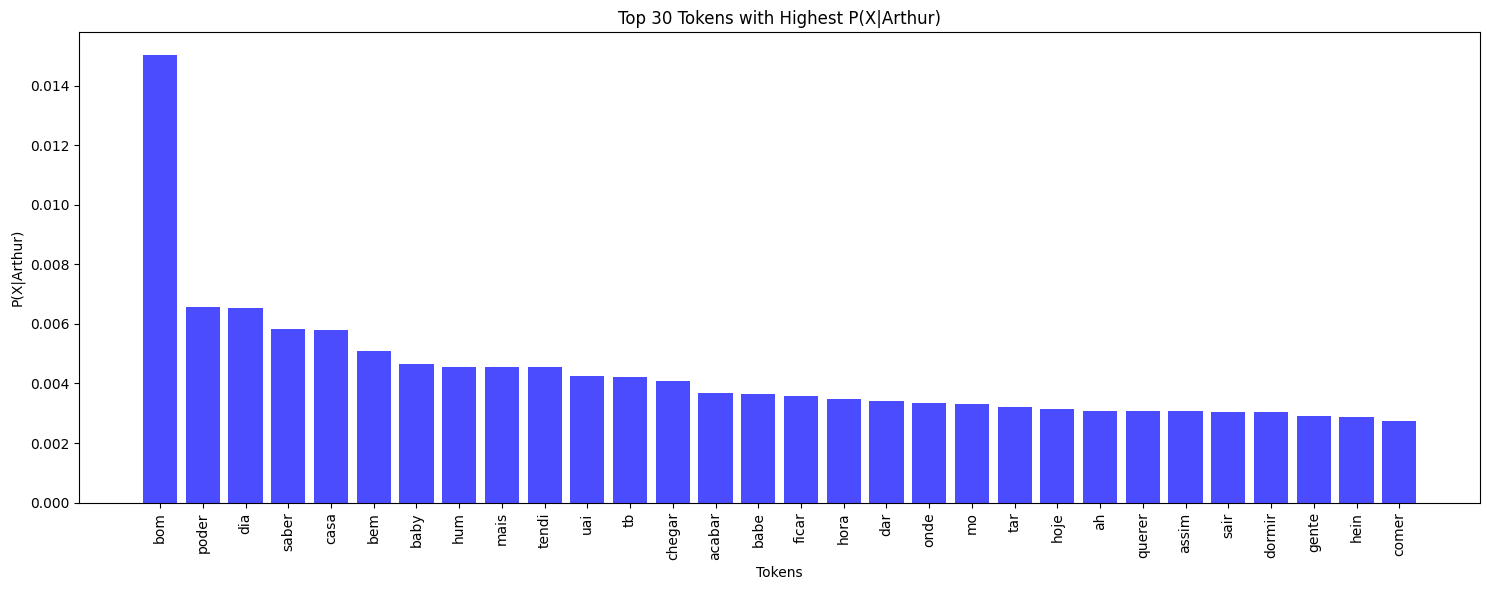

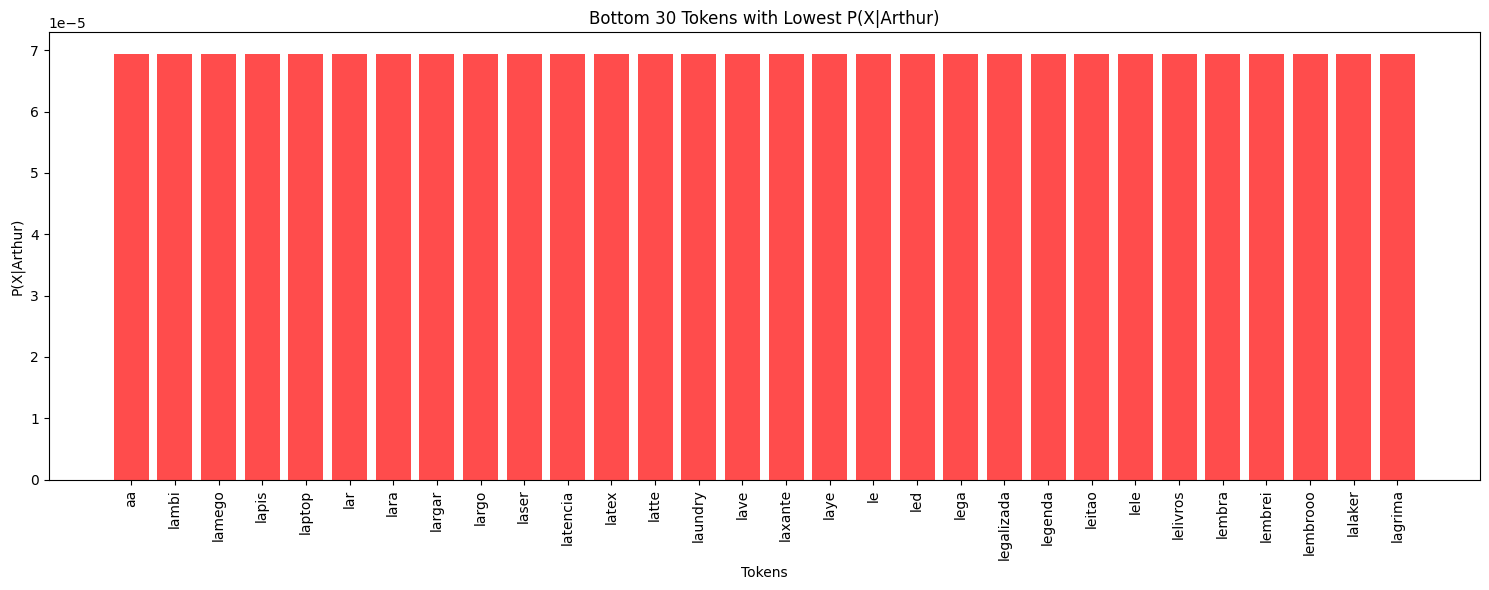

In [42]:
# Now I will do the same but considering Arthur's probabilities

# Extract token names from the vectorizer's vocabulary
vocabulary = pipeline_vectorizer.vocabulary_
tokens = np.array(sorted(vocabulary, key=vocabulary.get))  # Sort by index order

# For myself
feature_prob_arthur = np.exp(feature_log_prob[0])  # P(X|Arthur)

# Sort tokens by probability (descending and ascending)
sorted_indices_desc = np.argsort(-feature_prob_arthur)[:30]  # Top 30
sorted_indices_asc = np.argsort(feature_prob_arthur)[:30]    # Bottom 30

# Prepare data for plotting
top_tokens = tokens[sorted_indices_desc]
top_probs = feature_prob_arthur[sorted_indices_desc]
low_tokens = tokens[sorted_indices_asc]
low_probs = feature_prob_arthur[sorted_indices_asc]

# Plot top 30 tokens
plt.figure(figsize=(15, 6))
plt.bar(top_tokens, top_probs, color='blue', alpha=0.7)
plt.xticks(rotation=90)
plt.title('Top 30 Tokens with Highest P(X|Arthur)')
plt.ylabel('P(X|Arthur)')
plt.xlabel('Tokens')
plt.tight_layout()
plt.show()

# Plot bottom 30 tokens
plt.figure(figsize=(15, 6))
plt.bar(low_tokens, low_probs, color='red', alpha=0.7)
plt.xticks(rotation=90)
plt.title('Bottom 30 Tokens with Lowest P(X|Arthur)')
plt.ylabel('P(X|Arthur)')
plt.xlabel('Tokens')
plt.tight_layout()
plt.show()

## 7.1 Possible improvements

Since Arthur's and my tokens are so similar, maybe it’s not just about the meaning of the words (semantics) that the model should focus on. What if punctuation, emojis, and other little quirks could give the model better clues about who’s talking? So, I think it’s time to tweak my data preprocessing to include those fun details and see if that helps the model out.

Another thing I want to work on is getting more out of my entire dataset. Right now, I’m randomly sampling from the massive pile of messages I have, but maybe I could do some feature engineering to focus on the words and tokens that actually tell us apart — and ignore the ones that pop up too often in both of our chats.

Finally, I’m considering translating everything to English. Maybe the lemmatization and TF-IDF transformations will work better in English, which could give my model a little performance boost. It’s worth testing out!

# References

Bedigunjit. (2021, May 5). Simple guide to text classification (NLP) using SVM and Naive Bayes with Python. Medium. https://medium.com/@bedigunjit/simple-guide-to-text-classification-nlp-using-svm-and-naive-bayes-with-python-421db3a72d34

GeeksforGeeks. (n.d.). Removing stop words in NLTK Python. GeeksforGeeks. https://www.geeksforgeeks.org/removing-stop-words-nltk-python/

Kevin P. Murphy. (2012). Machine learning: A probabilistic perspective. MIT Press.

Machine Learning Mastery. (2020, January 1). Classification as conditional probability and the Naive Bayes algorithm. Machine Learning Mastery. https://machinelearningmastery.com/classification-as-conditional-probability-and-the-naive-bayes-algorithm/

Real Python. (2020, September 1). Natural language processing with spaCy in Python. Real Python. https://realpython.com/natural-language-processing-spacy-python/

Stack Exchange. (2019, October 21). When is the right moment to split the dataset? Data Science Stack Exchange. https://datascience.stackexchange.com/questions/118627/when-is-the-right-moment-to-split-the-dataset

ResearchGate. (n.d.). Geometric description of SVM for a binary classification problem. ResearchGate. https://www.researchgate.net/figure/Geometric-description-of-SVM-for-a-binary-classification-problem_fig14_224050262

# AI statement
I used Grammarly to help me with grammatical and spelling mistakes. I used ChatGPT to help me use the space and wordcloud library and to apply TF-IDF to my data sets. I also used ChatGPT to help me modify my Naive Bayes classifier to the SVM.